First three blocks are installs / imports for libraries

In [1]:
!pip install -U google-generativeai

In [2]:
!pip install PyPDF2 python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 11.8 MB/s eta 0:00:00


In [3]:
import os
import textwrap
import PyPDF2 # For PDF files | Probably don't need
import docx # For .docx Word files | Probably don't need
from IPython.display import display, Markdown, clear_output # For better Colab output
from PIL import Image
from io import BytesIO
from google import genai
from google.colab import userdata
from google.genai import types
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown, clear_output # For better Colab output
from google.colab import files


In [4]:
import time

Defining functions

In [5]:
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

client = genai.Client(api_key=GOOGLE_API_KEY)

#Names of the models for each part
text_gen_model = "gemini-1.5-flash"
#image_gen_model = "gemini-2.0-flash-preview-image-generation"
image_gen_model = "gemini-2.0-flash-exp-image-generation"

#Extracts text from a text (.txt) file
def get_txt(txt_path):
    """Extracts text from a plain text file."""
    try:
        with open(txt_path, 'r', encoding='utf-8') as file:
            return file.read()
    except UnicodeDecodeError:
        print(f"Error: Could not decode text file '{txt_path}' with UTF-8. Trying with 'latin-1'.")
        with open(txt_path, 'r', encoding='latin-1') as file:
            return file.read()
    except Exception as e:
        print(f"An error occurred while reading text file '{txt_path}': {e}")
        return None

#Given an image path, loads an image
def get_img(img_path):
  try:
    style_ex = Image.open(img_path)
  except FileNotFoundError:
    print(f"Error: {img_path} could not be found. Please try again")
    style_ex = Image.new('RGB', (100, 100), color = 'red')
    print("Creating replacement image, result will not be styled properly")

  return style_ex

##Creates a note, using time to prevent the error code 503.
def create_note(img_path):
  retries = 5  # Number of retries
  delay = 5    # Delay in seconds between retries

  for attempt in range(retries):
    try:
      my_file = client.files.upload(file=img_path)
      response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=[my_file, "Caption this image in a detailed manner. Make sure to point out characters and make descriptions about them."],
      )
      return(response.text)
    except Exception as e:
      print(f"Attempt {attempt + 1} failed: {e}")
      if attempt < retries - 1:
        print(f"Retrying in {delay} seconds...")
        time.sleep(delay)
      else:
        print("All retry attempts failed.")
        return None

def check_empty(text):
  text_list = text.split(" ")
  test2 = "".join(map(str, text_list))
  if test2 == "":
    return True
  else:
    return False

Attempting to print more than 3 images in one function call

In [6]:
def print_story(panels: dict):
  uneven = False
  rows = len(panels.keys()) // 3
  if len(panels.keys()) % 3 != 0:
    uneven = True

  for i in range(0, rows):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8)) # Create a figure and three subplots

    img1 = Image.open(panels[(i*3)][1]).convert("RGB")
    img1 = img1.resize((300,200))
    ax1.imshow(img1)
    ax1.axis("off")
    ax1_cap = textwrap.fill(f"{panels[(i*3)][0]}", width = 50)
    ax1.text(0.5, -0.1, ax1_cap, ha="center", va="top", transform=ax1.transAxes, wrap = True)

    img2 = Image.open(panels[(i*3)+1][1]).convert("RGB")
    img2 = img2.resize((300,200))
    ax2.imshow(img2)
    ax2.axis("off")
    ax2_cap = textwrap.fill(f"{panels[(i*3) + 1][0]}", width = 50)
    ax2.text(0.5, -0.1, ax2_cap, ha="center", va="top", transform=ax2.transAxes, wrap = True)

    img3 = Image.open(panels[(i*3)+2][1]).convert("RGB")
    img3 = img3.resize((300,200))
    ax3.imshow(img3)
    ax3.axis("off")
    ax3_cap = textwrap.fill(f"{panels[(i*3) + 2][0]}", width = 50)
    ax3.text(0.5, -0.1, ax3_cap, ha="center", va="top", transform=ax3.transAxes, wrap = True)

    plt.tight_layout() # Adjust layout to prevent text overlap
    plt.show()

  if uneven:
    columns = len(panels.keys()) % 3
    last_keys = list(panels.keys())[-1 * columns:]
    if columns == 1:
      fig, (ax1) = plt.subplots(1, 1, figsize=(15,8))

      img1 = Image.open(panels[last_keys[0]][1]).convert("RGB")
      img1 = img1.resize((300,200))
      ax1.imshow(img1)
      ax1.axis("off")
      ax1.text(0.5, -0.1, f"{panels[last_keys[0]][0]}", ha="center", va="top", transform=ax1.transAxes)

      plt.tight_layout()
      plt.show()

    elif columns == 2:
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

      img1 = Image.open(panels[last_keys[0]][1]).convert("RGB")
      img1 = img1.resize((300,200))
      ax1.imshow(img1)
      ax1.axis("off")
      ax1_cap = textwrap.fill(f"{panels[last_keys[0]][0]}", width = 75)
      ax1.text(0.5, -0.1, ax1_cap, ha="center", va="top", transform=ax1.transAxes, wrap = True)

      img2 = Image.open(panels[last_keys[1]][1]).convert("RGB")
      img2 = img2.resize((300,200))
      ax2.imshow(img2)
      ax2.axis("off")
      ax2_cap = textwrap.fill(f"{panels[last_keys[1]][0]}", width = 75)
      ax2.text(0.5, -0.1, ax2_cap, ha="center", va="top", transform=ax2.transAxes, wrap = True)

      plt.tight_layout()
      plt.show()

Generative Functions

In [7]:
"""
Text Generation | Programmed so that it can generate a story, and a title for the story.
The function needs to be called separately for generating both.
Parameters:
- out_type : "STORY" by default, generates the story : "TITLE" generates a story based on the 'prompt' input
- form : Changes the end of the prompt by specifying how the model should interpret the example text. Refer to the 'forms' dictionary
- prompt : if out_type is "STORY", insert the prompt for the story : if out_type is "TITLE", insert the story
- ex_txt : Example text to be used for the story's format (ONLY ONE) : Value doesn't matter when out_type is "TITLE"
- count : When out_type is "STORY", the story will be exactly 'count' sentences long : When out_type is "TITLE", the title will be exactly 'count' words long
"""
def GenText(prompt, ex_txt, count, out_type="STORY", form="INSPIRED"):
  forms = {"INSPIRED": "inspired by this style", "COPIED": "using this style", "SIMILAR": "in a form similar to this style"}
  if out_type.upper() == "STORY":
    print("WRITE STORY")
    final_prompt = (f"""
      Please use the following text as a style and tone guide:
      ---
      {ex_txt}
      ---

      Now, {forms[form]}, write a short story in {count} sentences, each sentence on a new line, about: {prompt}
    """)
  elif out_type.upper() == "TITLE":
    print("MAKE TITLE")
    final_prompt = (f"""
      Please read the following children story, and create a title for it that is exactly {count} words: {prompt}
    """)
  elif out_type.upper() == "SETTING":
    print("DESC SETTING")
    final_prompt = (f"""
      Please read the following children story and describe the setting where it would be taking place: {prompt}
    """)

  response = client.models.generate_content(
      model = text_gen_model,
      contents = final_prompt,
      config = types.GenerateContentConfig(
          response_modalities=['TEXT', 'Text']
      )
  )
  return response

"""
Image Generation | Generates an image
Parameters:
- prompt : The text prompt to create an image from
- ex_img : The image fed into the model as a style example (ONLY ONE IMAGE)
- file_name : File name for the generated image to be saved by, saved by "TEST.png" be default
- notes : To specify more about the prompt that isn't implied in the prompt already, since we're feeding sentences into the function
"""

def GenImage(prompt, setting, ex_img, file_name = "TEST.png", note = ""):
  final_prompt = f"""In a style inspired by the provided image, create an image for this caption: {prompt}
  The image should keep the following setting in mind: {setting} but be willing to change/modify it when it makes sense.
  Use this provided note to guide you and what has happened, and who is who: {note}
  Feel free to change the character positions and background elements, just maintain a consistent art style.
  the notes are meant as a reference to make sure everything is correct.
  You can change details in your images as long as they make sense contextually.
  """
  feed = (final_prompt, ex_img)

  response = client.models.generate_content(
      model = image_gen_model,
      contents = feed,
      config = types.GenerateContentConfig(
          response_modalities=['TEXT', "IMAGE"]
      ),
  )

  for part in response.candidates[0].content.parts:
    if part.text is not None:
      print(part.text)
    elif part.inline_data is not None:
      image = Image.open(BytesIO((part.inline_data.data)))
      image.save(file_name)
      image.show()

"""
Image Generation With Multiple Examples
Parameters:
- prompt : The text prompt to create an image from
- ex_imgs : A list of images fed into the model as a style example (MULTIPLE ALLOWED | CAN DO ONE)
"""
def GenImage_FromList(prompt, setting, ex_imgs, file_name = "TEST.png", note=""):
  final_prompt = f"""In a style inspired by the provided image, create an image for this caption: {prompt}
  The image should keep the following setting in mind: {setting} but be willing to change/modify it when it makes sense.
  Use this provided note to guide you and what has happened, and who is who: {note}
  Feel free to change the character positions and background elements, and maintain a consistent art style.
  Changes in background elements should make sense contextually.
  The notes are meant as a reference to ensure proper continuity.
  """
  feed = tuple([final_prompt] + ex_imgs)

  response = client.models.generate_content(
      model = image_gen_model,
      contents = feed,
      config = types.GenerateContentConfig(
          response_modalities=['TEXT', "IMAGE"]
      ),
  )

  for part in response.candidates[0].content.parts:
    if part.text is not None:
      print(part.text)
    elif part.inline_data is not None:
      image = Image.open(BytesIO((part.inline_data.data)))
      image.save(file_name)
      image.show()

In [12]:
#Generates the story
text_sample = get_txt("/content/drseuss(short).txt")
story_prompt = input("Enter a prompt to create a tale: ")
#story_prompt = input("Enter a prompt to create a tale: ")
story = GenText(story_prompt, text_sample, 9)

for part in story.candidates[0].content.parts:
  if part.text is not None:
    story_str = part.text

story_list_check = story_str.splitlines()
story_list = []
for i in story_list_check:
  if not check_empty(i):
    story_list.append(i)
#Prints the story line by line
for i in range(0, len(story_list)):
  print(str(i) + ": " + story_list[i])

Error: Could not decode text file '/content/drseuss(short).txt' with UTF-8. Trying with 'latin-1'.
Enter a prompt to create a tale: Three blue cranes train day and night by stretching their neck and pecking their beaks, led by a duck with a captain's hat
WRITE STORY
0: Three blue cranes, necks stretched long and thin, practiced their pecking.
1: Day and night, they diligently honed their skills, a blur of blue and motion.
2: Their leader, a surprisingly capable duck, wore a tiny captain's hat.
3: He squawked instructions, his voice surprisingly authoritative for such a small bird.
4: The cranes diligently repeated each exercise, mimicking the duck's precise movements.
5: They aimed for perfect form, a graceful ballet of beak and neck. 
6: Sweat beaded on their feathery foreheads; the training was intense.
7: But the duck's unwavering determination inspired the cranes to strive for perfection.
8: Soon, their synchronised pecking would amaze the whole marsh.


In [13]:
#Generates a title and prints it
title = GenText(story_str, None, 5, out_type="TITLE")

for part in title.candidates[0].content.parts:
  if part.text is not None:
    final_title = part.text

print(final_title)

MAKE TITLE
Captain Duck Trains Crane Ballet



In [14]:
setting = GenText(story_str, None, None, out_type="SETTING")
for part in setting.candidates[0].content.parts:
  if part.text is not None:
    final_setting = part.text

print(final_setting)

DESC SETTING
The setting is a marsh.  This is clearly indicated by the final sentence, "Soon, their synchronised pecking would amaze the whole marsh."  The description also implies a relatively open area where the birds can practice their movements freely.



Change the 'note' variable each time you generate an image for the caption. Some 'story relevant' info isn't implied in the caption, and the model will output a funky result

In [15]:
#Gets an image and generates a new one
img_sample = get_img("/content/drseuss.jpg")
notes = ""
panels = {}
images = [img_sample]
for i in range(0, len(story_list)):
  GenImage_FromList(story_list[i], setting, images, note=notes, file_name="OUT" + str(i) + ".png")
  #GenImage(story_list[i], final_setting, img_sample, file_name = "OUT" + str(i) + ".png", note=notes)
  panels[i] = [story_list[i] ,"OUT" + str(i) + ".png"]
  images.append(get_img(panels[i][1]))
  if len(images) >= 4:
    del images[0]
  notes = notes + " afterwards: " + create_note("OUT" + str(i) + ".png")

In the whimsical style of the provided image, I will depict three elegant blue cranes with long, slender necks gracefully extended. They will be positioned in a marshy setting, suggested by soft grasses and a calm body of water in the background, as they practice their pecking motions.


Attempt 1 failed: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
Retrying in 5 seconds...
In the whimsical style of Dr. Seuss, I will illustrate a scene in a marsh where three light blue, long-necked birds are diligently practicing their movements. Some will be captured in a sharp, focused pose, while others will appear as a fluid, blurry streak of blue, suggesting continuous motion throughout the day and night. The marsh will be depicted with stylized green grasses, simple horizontal lines indicating shallow water, and a background featuring a blend of yellow, light blue sky, and varied green and black vegetation, maint

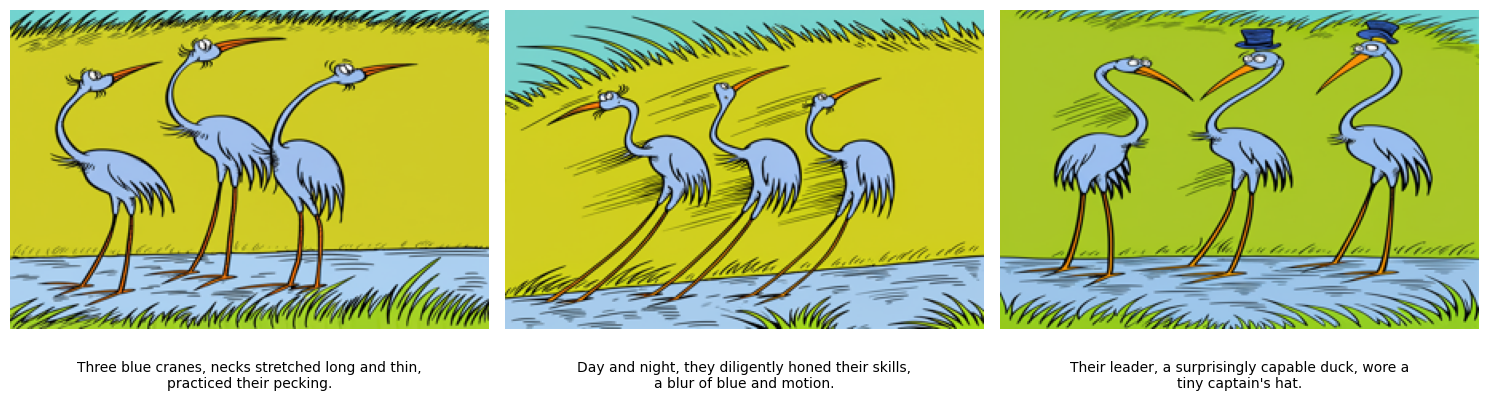

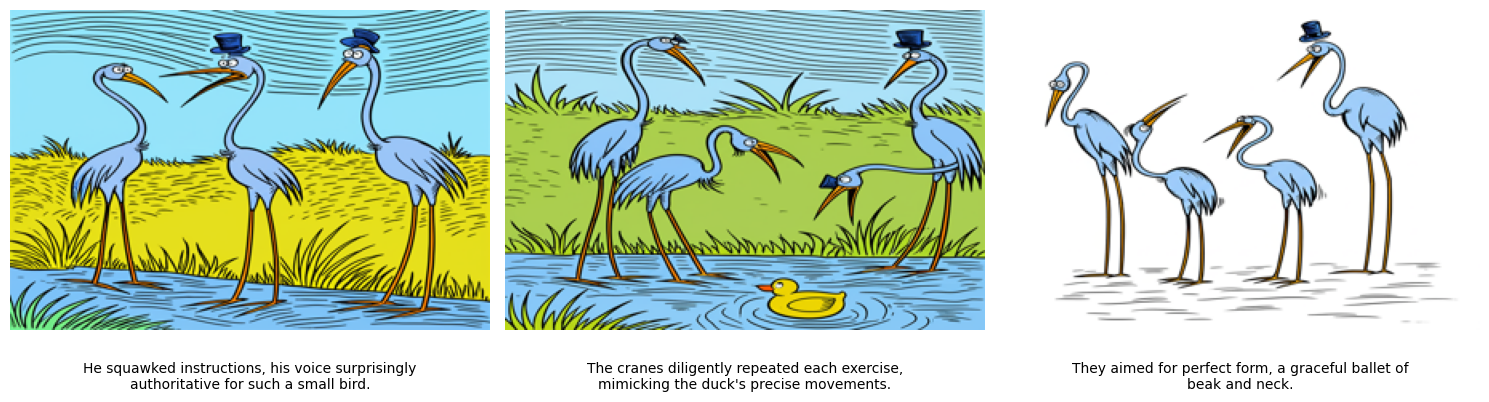

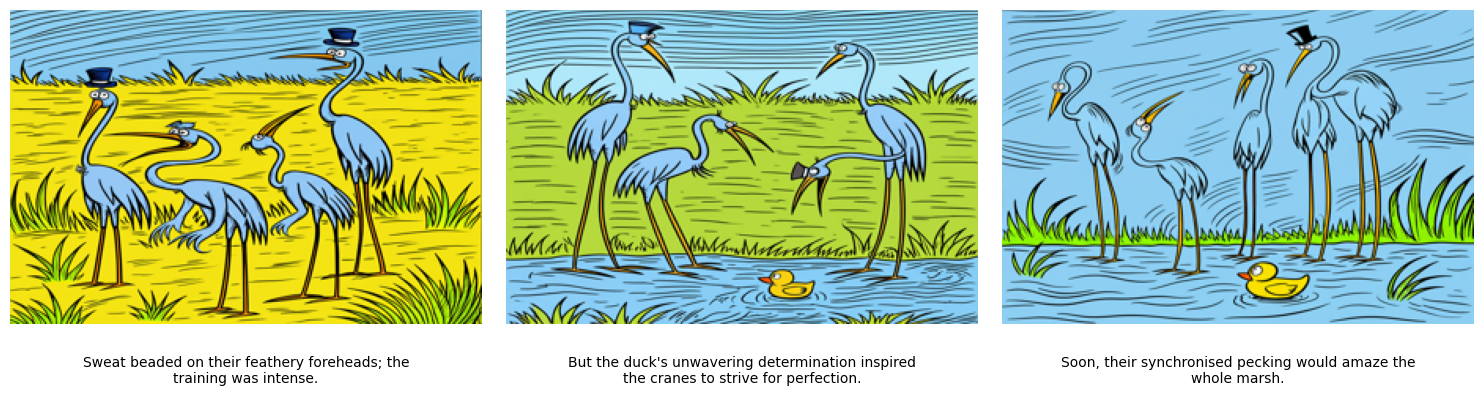

In [16]:
print_story(panels)